https://www.policinginstitute.org/publication/the-minneapolis-domestic-violence-experiment/

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List

from dowhy import CausalModel
import statsmodels.api as sm
# statsmodels' instrument variable implementation
from statsmodels.sandbox.regression.gmm import IV2SLS

# Display only double digits
pd.set_option('display.float_format', '{:.2f}'.format)

# Data Cleaning 

In [69]:
TREATMENT_CODE_NAME_MAPPING: Dict[int, str] = {
    1: 'Arrest',
    2: 'Advise',
    3: 'Separate',
}

In [70]:
data = pd.read_stata(
    "../data/mdve.dta"
)


data.head()

,ID,T_RANDOM,MONTH,YEAR,CLOCK,TIME,P_REPORT,CCN,V_RACE,S_RACE,...,P_ASSLT2,P_CALMED,P_REFER,P_ADVISE,T_FINAL,REASON1,REASON2,REASON3,REASON4,R_RELATE
0,372020123,3,5.00,81.00,125.00,35.00,1,83905.00,1,1.00,...,1.00,9.00,9.00,9.00,3,1.00,1.00,1.00,1.00,NaN
1,441050111,1,5.00,81.00,515.00,40.00,1,NaN,1,2.00,...,2.00,9.00,9.00,9.00,1,1.00,1.00,1.00,1.00,NaN
2,281200111,1,5.00,81.00,1910.00,15.00,1,77252.00,3,3.00,...,1.00,9.00,9.00,9.00,1,1.00,1.00,1.00,1.00,NaN
3,681260123,3,7.00,81.00,210.00,NaN,0,NaN,3,3.00,...,1.00,9.00,9.00,9.00,3,1.00,1.00,1.00,1.00,NaN
4,232010123,3,5.00,81.00,100.00,NaN,1,74836.00,1,1.00,...,1.00,9.00,9.00,9.00,3,9.00,1.00,1.00,1.00,NaN


In [71]:
# drop if the actual treatment is "other"
data = data[data['T_FINAL'] != 4]

# coddle
data['z_coddled'] = data['T_RANDOM'].apply(lambda x: 0 if x == 1 else 1)
data['d_coddled'] = data['T_FINAL'].apply(lambda x: 0 if x == 1 else 1)

In [72]:
data['y82'] = (data['YEAR'] == 82).astype(int)
data['q1'] = ((data['MONTH'] >= 1) & (data['MONTH'] <= 3)).astype(int)
data['q2'] = ((data['MONTH'] >= 4) & (data['MONTH'] <= 6)).astype(int)
data['q3'] = ((data['MONTH'] >= 7) & (data['MONTH'] <= 9)).astype(int)
data['black'] = (data['V_RACE'] == 2).astype(int)
data['native'] = (data['V_RACE'] == 3).astype(int)
data['other_nw'] = ((data['V_RACE'] >= 4) & (data['V_RACE'] <= 5)).astype(int)
data['mixed'] = (data['V_RACE'] != data['S_RACE']).astype(int)
data['s_influence'] = (data['S_CHEM'] == 1).astype(int)
data['gun_used'] = ((data['GUNS'] >= 2) & (data['GUNS'] <= 3)).astype(int)
data['o_weapon'] = ((data['WEAPON'] >= 4) & (data['WEAPON'] <= 5)).astype(int)
data['anyweapon'] = ((data['gun_used'] == 1) | (data['o_weapon'] == 1)).astype(int)
data['pol_asslt'] = (data['P_ASSLT2'] == 2).astype(int)
data['husband'] = (data['R_RELATE'] == 1).astype(int)
data['boyfriend'] = (data['R_RELATE'] == 5).astype(int)
data['nonwhite'] = (data['V_RACE'] != 1).astype(int)

In [73]:
data.shape

In [74]:
data.columns

Index(['ID', 'T_RANDOM', 'MONTH', 'YEAR', 'CLOCK', 'TIME', 'P_REPORT', 'CCN',
       'V_RACE', 'S_RACE', 'V_CHEM', 'S_CHEM', 'S_DMNOR1', 'S_DMNOR2',
       'WEAPON', 'GUNS', 'P_ASSLT1', 'P_ASSLT2', 'P_CALMED', 'P_REFER',
       'P_ADVISE', 'T_FINAL', 'REASON1', 'REASON2', 'REASON3', 'REASON4',
       'R_RELATE', 'z_coddled', 'd_coddled', 'y82', 'q1', 'q2', 'q3', 'black',
       'native', 'other_nw', 'mixed', 's_influence', 'gun_used', 'o_weapon',
       'anyweapon', 'pol_asslt', 'husband', 'boyfriend', 'nonwhite'],
      dtype='object')

## Generate Outcome Variables
Details can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FTZ8GN)

In [75]:
# data = data.sort_values(by="T_RANDOM")
# data['z_rank'] = np.linspace(0,1,data.shape[0])
# data = data.sort_values(by="T_FINAL")
# data['d_rank'] = np.linspace(0,1,data.shape[0])

In [91]:
data['z_rank'] = pd.qcut(data['T_RANDOM'], q=np.linspace(0, 1, data['T_RANDOM'].nunique()+1), labels=False, duplicates='drop') / data['T_RANDOM'].nunique()
data['d_rank'] = pd.qcut(data['T_FINAL'], q=np.linspace(0, 1, data['T_FINAL'].nunique()+1), labels=False, duplicates='drop') / data['T_FINAL'].nunique()

In [92]:
exp_params: Dict[str, float] = {
    'pz_separ': 1 / (1 + np.exp(1.21)), 
    'pz_arrest': 1 / (1 + np.exp(1.21 + 0.9)), 
    'pz_advise': 1 / (1 + np.exp(1.21 + 0.21)),
    
    'pd_separ': 1 / (1 + np.exp(1.05)), 
    'pd_arrest': 1 / (1 + np.exp(1.05 + 0.82)), 
    'pd_advise': 1 / (1 + np.exp(1.05 + 0.46))
}

In [94]:
data['fail_z'] = (
    ((data['T_RANDOM'] == 1) & (data['z_rank'] < exp_params['pz_arrest']))
    | ((data['T_RANDOM'] == 2) & (data['z_rank'] < exp_params['pz_advise']))
    | ((data['T_RANDOM'] == 3) & (data['z_rank'] < exp_params['pz_separ']))
).astype(int)

data['fail_d'] = (
    ((data['T_FINAL'] == 1) & (data['d_rank'] < exp_params['pd_arrest']))
    | ((data['T_FINAL'] == 2) & (data['d_rank'] < exp_params['pd_advise']))
    | ((data['T_FINAL'] == 3) & (data['d_rank'] < exp_params['pd_separ']))
).astype(int)

data.head()

,ID,T_RANDOM,MONTH,YEAR,CLOCK,TIME,P_REPORT,CCN,V_RACE,S_RACE,...,o_weapon,anyweapon,pol_asslt,husband,boyfriend,nonwhite,z_rank,d_rank,fail_z,fail_d
161,1591260111,1,3.00,82.00,2000.00,15.00,1,NaN,1,1.00,...,0,0,0,0,0,0,0.00,0.00,1,1
49,652150112,2,5.00,81.00,415.00,NaN,1,NaN,3,3.00,...,0,0,0,0,0,1,0.00,0.00,1,1
101,1331130112,2,12.00,81.00,700.00,30.00,1,NaN,1,1.00,...,0,0,0,0,0,0,0.00,0.00,1,1
39,162090123,3,4.00,81.00,1800.00,NaN,1,NaN,1,2.00,...,0,0,0,0,0,0,0.33,0.00,0,1
169,2032480132,2,2.00,82.00,1650.00,25.00,1,NaN,3,1.00,...,1,1,0,0,0,1,0.00,0.00,1,1


## Calculate Assigned and Delivered Treatments

The table 3.3 in Chapter 3

In [95]:
compliance_data = (
    data
    .groupby(by=['T_RANDOM', 'T_FINAL'])
    .agg({'ID': 'count'})
    .reset_index()
    .pivot_table(
        values='ID',
        index='T_RANDOM',
        columns='T_FINAL'
    )
    .fillna(0)
    .astype(int)
    .rename(
        index=TREATMENT_CODE_NAME_MAPPING,
        columns=TREATMENT_CODE_NAME_MAPPING
    )
)

compliance_data = (
    compliance_data
    .div(compliance_data.sum(axis=1), axis=0)
    * 100
)

compliance_data

T_FINAL,Arrest,Advise,Separate
T_RANDOM,,,
Arrest,98.91,0.00,1.09
Advise,17.59,77.78,4.63
Separate,22.81,4.39,72.81


# Causal Inference

## `DoWhy` Implementation

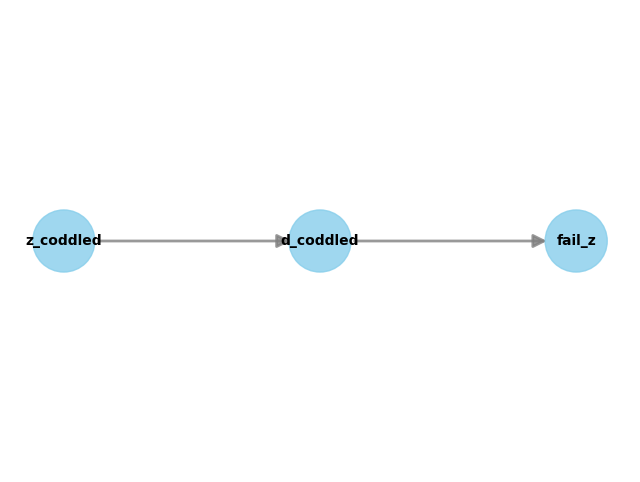

In [116]:
model = CausalModel(
    data=data,
    outcome='fail_z',
    treatment='d_coddled',
    instruments='z_coddled',
    common_causes='y82 q1 q2 q3 nonwhite mixed anyweapon s_influence'.split(' ')
)

model.view_model()

In [117]:
identified_estimand = model.identify_effect()
identified_estimand.estimands

{'backdoor1': {'estimand': Derivative(Expectation(fail_z), [d_coddled]),
  'assumptions': {'Unconfoundedness': 'If U→{d_coddled} and U→fail_z then P(fail_z|d_coddled,,U) = P(fail_z|d_coddled,)'}},
 'backdoor2': {'estimand': Derivative(Expectation(fail_z|z_coddled), [d_coddled]),
  'assumptions': {'Unconfoundedness': 'If U→{d_coddled} and U→fail_z then P(fail_z|d_coddled,z_coddled,U) = P(fail_z|d_coddled,z_coddled)'}},
 'backdoor3': {'estimand': Derivative(Expectation(fail_z|z_coddled), [d_coddled]),
  'assumptions': {'Unconfoundedness': 'If U→{d_coddled} and U→fail_z then P(fail_z|d_coddled,z_coddled,U) = P(fail_z|d_coddled,z_coddled)'}},
 'backdoor': {'estimand': Derivative(Expectation(fail_z), [d_coddled]),
  'assumptions': {'Unconfoundedness': 'If U→{d_coddled} and U→fail_z then P(fail_z|d_coddled,,U) = P(fail_z|d_coddled,)'}},
 'iv': {'estimand': Expectation(Derivative(fail_z, [z_coddled])*Derivative([d_coddled], [z_coddled])**(-1)),
  'assumptions': {'As-if-random': 'If U→→fail_z 

In [118]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable",
    test_significance=True
)

print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                -1⎤
 ⎢     d               ⎛     d                   ⎞  ⎥
E⎢────────────(fail_z)⋅⎜────────────([d_coddled])⎟  ⎥
 ⎣d[z_coddled]         ⎝d[z_coddled]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→fail_z then ¬(U →→{z_coddled})
Estimand assumption 2, Exclusion: If we remove {z_coddled}→{d_coddled}, then ¬({z_coddled}→fail_z)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡    d             ⎤  -1⎡    d                ⎤
E⎢──────────(fail_z)⎥⋅E  ⎢──────────(d_coddled)⎥
 ⎣dz_coddled        ⎦    ⎣dz_coddled           ⎦
Estimand assumption 1, As-if-random: If U→→fail_z then ¬(U →→{z_coddled})
Estimand assumption 2, Exclusion: If we remove {z_coddled}→{d_coddled}, then ¬({z_coddled}→fail_z)
Estimand

## `statsmodels` Implementation

In [119]:
model = IV2SLS(
    endog=data['fail_z'],
    exog=data['d_coddled'],
    instrument=data['z_coddled']
)

results = model.fit()
print(results.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                 fail_z   R-squared:                       0.218
Model:                         IV2SLS   Adj. R-squared:                  0.215
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Mon, 08 Jan 2024                                         
Time:                        19:05:29                                         
No. Observations:                 314                                         
Df Residuals:                     313                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d_coddled      0.6102      0.060     10.253      0.0